<a href="https://colab.research.google.com/github/James-Kervin/PHY480_Sem_Proj/blob/main/PHY480_JamesKervinProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### PHY 480/905 Semester Project
###  Author: James Kervin
#### Last Updated: 

# Modling of a Photovioltaic cell

##  Introduction 

Optical physics is pivotal for many of our modern day technologies. Everything from laser cutters in factories, to fiber optic internet, to everyday remotes came from an understanding of how electromagnetic waves could be used to achieve a purpose. When constructing these technologies and experimenting with light to find new useful properties measuring the light accurately helps quantify and standardize all testing. This measuring of the light can’t be done with any tool that relies on human sight, humans can only see 380 to 750 nm wavelengths, and many electromagnetic waves lie outside that range. To alleviate this problem photovoltaics were invented as a consistent method of measuring electromagnetic waves.

Photovoltaics are devices that use semiconductors to generate voltage when struck with light. This voltage can then be connected to a circuit and the current generated through that circuit. This current is related to the light incident through a variety of material properties and can be used to quantify the light incident upon the device. 

In this notebook a mathematical model of a photovoltaic is constructed, this model will take in the wavelengths expected and the power expected from the light source to be measured it will then return the amount of current generated. This is useful for testing something such as a laser or testing how much current is expected at the end of fiber optic cable.


## Methodology

With the goal to create a mathematical model of the photovoltaic, the first thing that must be done is to collect all of the equations that model the characteristics of the semiconductor. These equations will then be solved using python. To stay with good coding practice the metric units and libraries used in the following notebook are all placed in the cell below.

In [43]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
import time

#metric units
nano = 10**-9
u = 10**-6
m = 10**-3

#plank constant
h = 4.1356*10**-15 #ev/Hz
#speed of light
c = 3*10**8 #m/s
#charge of an electron
q = 1.602*10**-19 #coulombs

Current generated from light incident on the photovoltaic is  a result of the light exciting electrons from the valence band to the conduction band of the semiconductor device. This excitation creates an electron hole pair which is then moved through the circuit. This excitation however is dependent on a number of material properties. To simplify this model the following properties are assumed below. The model used will be made from PN junction of silicon. The extinction coefficient helps determine the absorption coefficient and the diffusion length is the range a newly excited electron will travel. Finally the band gap is the potential difference between the valence and conduction band. 

In [44]:
k = 2 #extinction coefficent
L = 1*m # diffusion length
Band_gap = 1.1242 #eV

### Modeling light source

Light has a very well known particle wave duality, therefore for the model an accurate representation needs to be made that works with both characteristics. This sensor is a photovoltaic and designed to operate on electromagnetic waves shorter than microwaves and larger than radiation waves so these waves can be ignored. However, since the semiconductor used is going to be made of silicon its band gap characteristics limit the usable wavelengths further. While doping could be used  to change the band gap this project will assume it stays the same as the constant defined above. WIth this all wavelengths that do not have enough energy to excite an electron across the band gap can be ignored. As to excite and electron hole the photon must send the electron to at least the edge of the conduction band. The longest wave that still has this amount of potential can be defined with the following equation:
$$ \lambda (m)  = \frac{h (eV/Hz) * c (m/s)}{ \text{Photon Energy (eV)}} $$


In [45]:
print("Maximum wavelength: {:.4f} nm".format( h* c * Band_gap * 1/nano) ) 

Maximum wavelength: 1394.7725 nm


Now that it is known that all wavelengths larger than 1390 nm can be ignored the next step is to find the number of photons currently incident on the photovoltaic, this value can then be multiplied by how many of these photons are absorbed to determine how many electron hole pairs are generated.

For simplicity of the project to find the number of photons the total energy will be divided by the summation of photon energies for each wavelength in the light burst. The equation for this is shown below.


$$\frac{\text{Total Energy}}{\text{Energy of each Photon}} = \frac{1 mW }{\int_{\lambda_{min}}^{\lambda_{max}} (h* c / \lambda) d \lambda} = \text{Number of Photons}$$

In [46]:
def GetNumberOfPhotons(watts, wavelength1, wavelength2):  
  #convert watts to eV   1 eV = 1.602176487⋅10-19 Ws
  ev_total = watts * 4.14 *10**15

  #readjust the wavelength range if outside acceptable range
  if wavelength2 > 1390 *nano:
    wavelength2 = 1390 *nano
  if wavelength1 < 1 *nano:
    wavelength1 = 1*nano

  #integral of h*c / lambda 
  equation = lambda x : h*c * np.log(x)
  
  return ev_total / (equation(wavelength2) - equation(wavelength1))


### Modeling Light absorption

With a model for light created the next is to define the equations for absorption of the photon. From [1] the absorption coefficient can be derived using the equation below. Where k is the extinction coefficient of the material.

$$ \alpha = \frac{4 \pi k}{\lambda} $$


In [47]:
#create function to find alpha (needs to be in terms of cm)
def Getalpha(_k, wavelength):
  return 4 * np.pi * _k / wavelength

With the absorption coefficient the generation rate of electron hole pairs can then be calculated. It is known that light intensity drops exponentially the further into the material. It is also known that the initial number of photons incident on the sensor will have an initial absorption. This initial absorption will remove photons from later use. This can be combined into the following generation equation rate equation


$$ G = \alpha N_0 e^{- \alpha *x } $$

Where N_0 is the incident  photons/unit-area/sec and x is the depth into the sensor. The functions are defined in python for later use.


In [48]:
#create function to determine generation rate at depth x
def G(wavelength, _k, N_0, x):
  a = Getalpha(_k, wavelength)
  return a * N_0 *np.exp(-a * x)

### Model Collection Probability

Now that the generation rate equation is created the next step is to find the probability that the electron hole pair is turned into current. A standard photovoltaic is made of a P and N side, each side opposite dropped so that when an electron/hole enters the other side it is pushed through the connected circuit to recombine. An example diagram is shown below. 

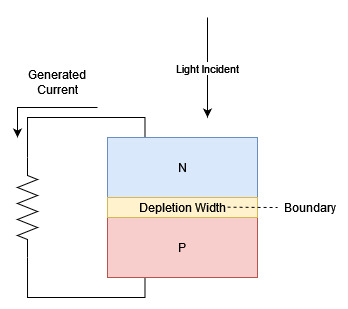

For an electron hole pair to become current one of the pairs must first cross the depletion width or the neutral charge zone between the P and N side. The probability of the charge crossing can be found using the average diffusion length of the silicon and the distance from the boundary as shown in the equation below. [3]

$$ CP(x) = e^{\frac{x}{L}}$$


In [49]:
def CP(x, _L):
  return np.exp(-x/_L)

The function above relies on the  distance from the boundary and the current point. Finding this distance can be placed into a function as it is an action that will need to be repeated. This distance function also needs the ability to handle both a list of values and a singular value, therefore the following equation was created. 

In [50]:
def Adjusted_depth(x, depletion_width, boundry):
  #find distance from middle of boundray
  d = abs(x-boundry)
  #return distance from deplition edge
  d = d - depletion_width/2
  #adjust the value so that if x is inside the deplition width we return 0
  if type(d) == type(3.14) or type(d) == type(np.float64(3.14)):
    # d is a singular value
    if d > 0:
      return d
    else:
      return 0
  else:
    # d is an array of values so we must search each individual value

    for i in range(len(d)):
      if d[i] < 0:
        d[i] = 0
    return d

### Defining Current Equation

Now the probability of collection can be multiplied by the generation giving the number of generated holes that will cross the boundary and become current. This can be integrated over the thickness of the sensor and then multiplied by the area of the sensor. Resulting in the below double integration. 


$$ J = q \int_{0}^{\text{Thickness}} G(x, \lambda)CP(x) dx  = q \int_{0}^{\text{Thickness}} ( \int_{\lambda_0}^{\lambda_1}G(x, \lambda) d \lambda )* CP(x) dx $$

### Executing the Integration
With the final mathematical model created for the sensor, the next step is to develop a way of executing the integration terms.  Doing the integration by hand and then typing in the derived  formulas would be the best method, as it would be fast to execute and very accurate. However, because of the generation equation the antiderivative is non-elementary ( $ \frac{1}{\lambda}*e^{1/\lambda} $ ). Therefore to calculate this would be very time consuming and require additional functions to be declared. 
Instead numerical integration methods can be used to evaluate very close to the true answer and will give a number within a set tolerance. The question then becomes which numerical integration method is best for this model. To determine this project tests the trapezoidal, Gaussian Quadrature, Romberg, and Simpsons methods. 
In each of the below methods the function `Current(d)` is created internal to the model, this function it calls the same method of integration on the generation function on the range of wavelengths in the burst of light. This function then calculates the current using the collection probability and the result of the integration of all generation at that depth. This current equation is then integrated and multiplied by electron charge to get total current density. 


#### Trapezoidal method
This method uses a self-written trapezoidal integration python function.

In [51]:
def trapezoidal_rule(F, N, start, stop):
    #create each edge
    steps = np.linspace(start, stop, N+1)
    
    #find width of each trapezoid
    h = (stop-start)/N
    
    #add stop and start points
    integration_val = 0.5*F(start)+ 0.5*F(stop)
    
    for k in range(1, N):
        integration_val += F(steps[k])
    
    #multiply all by base width
    integration_val *= h
    
    return integration_val
    

In [52]:
def Trap_Model(Num_steps, k, N0, wave1, wave2, A, boundry, d_width):
  def Current(d):


    #find the generation rate at depth d
    Generation_Rate = lambda wave : G(wave, k, N0, d)
    #Find integration of generation rate
    G_wavelengths = trapezoidal_rule(Generation_Rate, 100, wave1 *10**5, wave2 *10**5)

    #find distance from deplition width
    d_dep = Adjusted_depth(d, d_width , boundry )

    #define collection at depth d
    Collection_prob = CP(d_dep, L)
    return G_wavelengths*Collection_prob

  start_time = time.time()
  #find integration of the entire depth
  J_trapez = q *  trapezoidal_rule(Current, Num_steps, 0, thickness)
  J_trapez *= A
  
  T_trapez = time.time() - start_time
  print("{:.3f} seconds to run".format(T_trapez))
  print("Total Current: {:.4}".format(J_trapez))

  return J_trapez, T_trapez

#### Gaussian Quadrature
This uses the Guassian Quadrature method from PHY 480

In [53]:
def gaussxw(N):

    # Initial approximation to roots of the Legendre polynomial
    a = np.linspace(3, 4*N-1, N)/(4*N+2)
    x = np.cos(np.pi*a+1/(8*N*N*np.tan(a)))
    
    # Find roots using Newton's method
    epsilon = 1e-15
    delta = 1.0

    #check if we have reached below a threshold
    while delta > epsilon:
        p0 = np.ones(N, float)
        p1 = np.copy(x)
        
        for k in range(1, N):
            p0,p1 = p1,((2*k+1)*x*p1 - k*p0)/(k+1)
        
        dp = (N+1)*(p0-x*p1)/(1-x*x)
        dx = p1/dp
        x -= dx
        delta = max(np.abs(dx))

    # Calculate the weights
    w = 2*(N+1)*(N+1)/(N*N*(1-x*x)*dp*dp)

    return x,w


def gaussxwab(N, a, b):
    x, w = gaussxw(N)
    #returns x converted to -1 to 1 range and the adjusted weight function
    return 0.5*(b-a)*x + 0.5*(b+a), 0.5*(b-a)*w

In [54]:
def Gauss_model(Num_steps, k, N0, wave1, wave2, A, boundry, d_width):
  def Current(d):
    #find distance from deplition width
    d_dep = Adjusted_depth(d, d_width , boundry )

    #find the generation rate at depth d
    Generation_Rate = lambda wave : G(wave, k, N0, d)
    #Find integration of generation rate
    x, w = gaussxwab(Num_steps, wave1, wave2)
    G_wavelengths = np.sum(w*Generation_Rate(x))

    #define collection at distance d from midpoint
    Collection_prob = CP(d_dep, L)

    return G_wavelengths*Collection_prob

  start_time = time.time()
  #find integration of the entire depth
  x, w = gaussxwab(Num_steps, 0, thickness)
  J_gauss = q *  np.sum(w*Current(x))
  J_gauss *= A
  
  T_gauss = time.time() - start_time

  print("{:.3f} seconds to run".format(T_gauss))
  print("Total Current: {:.4}".format(J_gauss))

  return J_gauss, T_gauss

####  Romberg Integration Method
This method uses the Sympy Integration library [4]

In [55]:
def Romberg_model(k, N0, wave1, wave2, A, boundry, d_width):
  def Current(d):
    #find distance from deplition width
    d_dep = Adjusted_depth(d, d_width , boundry )

    #find the generation rate at depth d
    Generation_Rate = lambda wave : G(wave, k, N0, d)
    #Find integration of generation rate
    G_wavelengths = integrate.romberg(Generation_Rate, wave1, wave2)

    #find the generation rate at depth d
    Generation_Rate = lambda wave : G(wave, k, N0, d)
    #Find integration of generation rate
    G_wavelengths = integrate.romberg(Generation_Rate, wave1, wave2)

    #define collection at depth d
    Collection_prob = CP(d_dep, L)

    return G_wavelengths*Collection_prob

  start_time = time.time()
  J_rom = q * integrate.romberg(Current, 0, thickness)
  J_rom *= A

  T_rom = time.time() - start_time

  print("{:.3f} seconds to run".format(T_rom))
  print("Total Current: {:.4}".format(J_rom))
  

  return J_rom, T_rom

#### Simpsons
This method uses the Sympy Integration library [4]

In [56]:
def Simps_model(Num_steps, k, N0, wave1, wave2, A, boundry, d_width):
  def Current(d):
    #find distance from deplition width
    d_dep = Adjusted_depth(d, d_width , boundry )


    #find the generation rate at depth d
    Generation_Rate = lambda wave : G(wave, k, N0, d)
    #Find integration of generation rate
    wavelengthRange = np.linspace(wave1, wave2, Num_steps)
    G_wavelengths = integrate.simpson(Generation_Rate(wavelengthRange), dx = (wave2 - wave1)/Num_steps)

    #define collection at depth d
    Collection_prob = CP(d_dep, L)

    return G_wavelengths*Collection_prob
  
  start_time = time.time()
  d = np.linspace(0, thickness, Num_steps)
  J_simps = q * integrate.simpson(Current(d), dx = thickness/ Num_steps)
  J_simps *= A
  T_simps = time.time() - start_time

  print("{:.3f} seconds to run".format(T_simps))
  print("Total Current: {:.4}".format(J_simps))
  

  return J_simps, T_simps

Now with all of the methods of integration created they can be tested when calculating the current for different light bursts. For this model to produce a results all fo the following characteristics will need to be entered into each model:

- Minimum wavelength in the burst of light
- Maximum wavelength in the burst of light 
- Extinction coefficient of the material
- Number of photons incident
- Area of the sensor
- The depth at which the boundary between the P and N junction sits.


The first situation the models can be tested with is a burst of light with a spectrum of 500 nm to 510 nm or a near monochromatic light burst. The thickness of the device will be 5mm and the boundary will occur at the 2 mm depth. The surface area will be 2cm by 2cm and the power expected is 500 $\mu$ watts. Given these characteristics, what does each model predict the current will be?

In [57]:
J_gauss = []
J_trapz = []
J_rom   = []
J_simps = []

T_gauss = []
T_trapz = []
T_rom   = []
T_simps = []

In [58]:
#define wavelength range
wave1 = 500*nano
wave2 = 510*nano
#define thickness of sensor
thickness = 5*m
#define where the PN junction is in the semiconductor
boundry = 2*m
d_width = 0.5*m
#surface area of the sensor (2x2 cm)
area = ( .02 )**2
N0 = GetNumberOfPhotons(500*u, wave1, wave2)
Num_steps = 10**4

print("Trapezoidal")
J, T = Trap_Model(Num_steps,k, N0, wave1*10**5, wave2*10**5, area, boundry, d_width)
J_trapz.append(J)
T_trapz.append(T)
print("Gaussian")
J, T = Gauss_model(Num_steps,k, N0, wave1*10**5, wave2*10**5, area, boundry, d_width)
J_gauss.append(J)
T_gauss.append(T)
print("Romberg")
J, T = Romberg_model( k, N0, wave1*10**5, wave2*10**5, area, boundry, d_width)
J_rom.append(J)
T_rom.append(T)
print("Simpsons")
J, T = Simps_model(Num_steps, k, N0, wave1*10**5, wave2*10**5, area, boundry, d_width)
J_simps.append(J)
T_simps.append(T)

Trapezoidal
3.305 seconds to run
Total Current: 6.079e-06
Gaussian
3.110 seconds to run
Total Current: 2.249e-06
Romberg
0.226 seconds to run
Total Current: 2.383e-06
Simpsons
0.009 seconds to run
Total Current: 2.248e-06


These results are further explored in the results section. Next the models are tested again with a non-monochromatic light source with almost all other characteristics remaining constant. 

In [59]:
#define wavelength range
wave1 = 500*nano
wave2 = 600*nano
#define thickness of sensor
thickness = 5*m
#define where the PN junction is in the semiconductor
boundry = 2*m
d_width = 0.5*m
#surface area of the sensor (2x2 cm)
area = ( .02 )**2
N0 = GetNumberOfPhotons(500*u, wave1, wave2)
Num_steps = 10**4

print("Trapezoidal")
J, T = Trap_Model(Num_steps,k, N0, wave1*10**5, wave2*10**5, area, boundry, d_width)
J_trapz.append(J)
T_trapz.append(T)
print("Gaussian")
J, T = Gauss_model(Num_steps,k, N0, wave1*10**5, wave2*10**5, area, boundry, d_width)
J_gauss.append(J)
T_gauss.append(T)
print("Romberg")
J, T = Romberg_model( k, N0, wave1*10**5, wave2*10**5, area, boundry, d_width)
J_rom.append(J)
T_rom.append(T)
print("Simpsons")
J, T = Simps_model(Num_steps, k, N0, wave1*10**5, wave2*10**5, area, boundry, d_width)
J_simps.append(J)
T_simps.append(T)

Trapezoidal
3.594 seconds to run
Total Current: 6.079e-06
Gaussian
2.495 seconds to run
Total Current: 2.47e-06
Romberg
0.264 seconds to run
Total Current: 2.544e-06
Simpsons
0.008 seconds to run
Total Current: 2.47e-06


The final test conducted is with the same wavelength spectrum as the last test but now the thickness and power changed.

In [60]:
#define wavelength range
wave1 = 500*nano
wave2 = 600*nano
#define thickness of sensor
thickness = 2*m
#define where the PN junction is in the semiconductor
boundry = .1*m
d_width = 0.5*m
#surface area of the sensor (2x2 cm)
area = ( .02 )**2
N0 = GetNumberOfPhotons(800*u, wave1, wave2)
Num_steps = 10**4

print("Trapezoidal")
J, T = Trap_Model(Num_steps,k, N0, wave1*10**5, wave2*10**5, area, boundry, d_width)
J_trapz.append(J)
T_trapz.append(T)
print("Gaussian")
J, T = Gauss_model(Num_steps,k, N0, wave1*10**5, wave2*10**5, area, boundry, d_width)
J_gauss.append(J)
T_gauss.append(T)
print("Romberg")
J, T = Romberg_model( k, N0, wave1*10**5, wave2*10**5, area, boundry, d_width)
J_rom.append(J)
T_rom.append(T)
print("Simpsons")
J, T = Simps_model(Num_steps, k, N0, wave1*10**5, wave2*10**5, area, boundry, d_width)
J_simps.append(J)
T_simps.append(T)

Trapezoidal
3.248 seconds to run
Total Current: 4.978e-06
Gaussian
3.075 seconds to run
Total Current: 3.329e-06
Romberg
0.326 seconds to run
Total Current: 3.673e-06
Simpsons
0.009 seconds to run
Total Current: 3.328e-06


With the above models created and the code run the results can be analyzed

## Results and Discussion

Before comparing the effectiveness of each integration model, the collected functions should be analyzed to ensure that they produce accurate results. To compare them the below cell plots the generation rate, collection probability, and current density as functions of depth into the sensor. 

In [61]:
#define wavelength range
wave1 = 500*nano
wave2 = 510*nano
#define thickness of sensor
thickness = 5*m
#define where the PN junction is in the semiconductor
boundry = 2*m
d_width = 0.5*m
#surface area of the sensor (2x2 cm)
area = ( .02 )**2
N0 = GetNumberOfPhotons(500*u, wave1, wave2)
Num_steps = 10**4

C_list = []
G_list = []
J_list = []
def Current(d):
  #find distance from deplition width
  d_dep = Adjusted_depth(d, d_width , boundry )

  #find the generation rate at depth d
  Generation_Rate = lambda wave : G(wave, k, N0, d)
  #Find integration of generation rate
  G_wavelengths = trapezoidal_rule(Generation_Rate, 100, wave1*10**5, wave2*10**5 )
  
  G_list.append(G_wavelengths)


  #define collection at distance d from midpoint
  Collection_prob = CP(d_dep, L)
  C_list.append(Collection_prob)

  J = G_wavelengths*Collection_prob
  J_list.append(J)

  return J

trapezoidal_rule(Current, Num_steps, 0, thickness)



3.719020641602041e+16

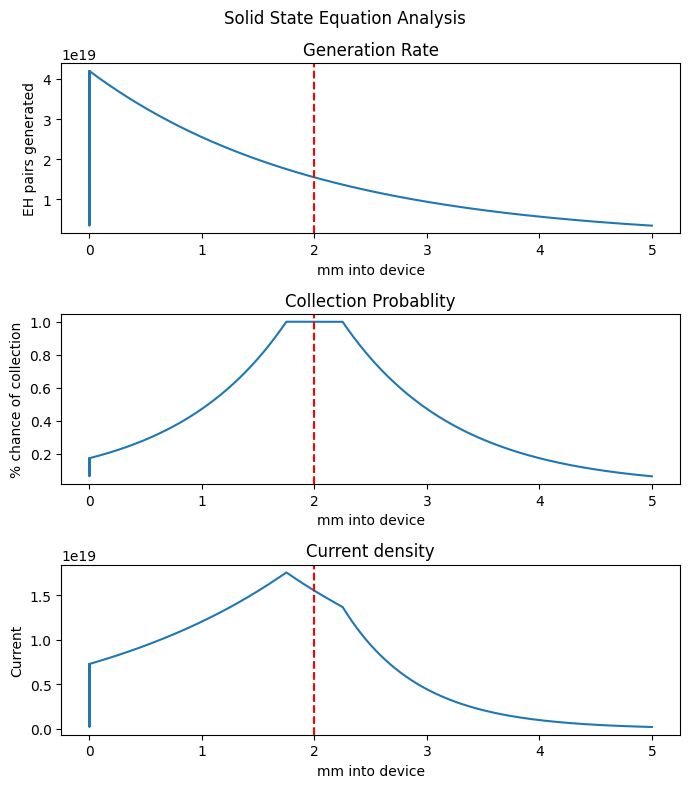

In [62]:
#plot results

fig, axs = plt.subplots(3)
fig.suptitle('Solid State Equation Analysis')

fig.set_figheight(8)
fig.set_figwidth(7)


d = np.linspace(0, thickness, Num_steps+1)



axs[0].plot(d*1/m, G_list)
axs[0].set_title("Generation Rate")
axs[0].axvline(boundry*1/m, color = 'r', linestyle = '--')
axs[0].set_xlabel("mm into device")
axs[0].set_ylabel("EH pairs generated")


axs[1].plot( d*1/m , C_list)
axs[1].set_title("Collection Probablity")
axs[1].axvline(boundry*1/m, color = 'r', linestyle = '--')
axs[1].set_xlabel("mm into device")
axs[1].set_ylabel("% chance of collection")


axs[2].plot(d*1/m, J_list)
axs[2].set_title("Current density")
axs[2].axvline(boundry*1/m, color = 'r', linestyle = '--')
axs[2].set_xlabel("mm into device")
axs[2].set_ylabel("Current")


plt.tight_layout()
plt.show()



The above graphs show that our generation, collection probability, and generation rate create accurate representations of what is expected within the sensor. The generation rate drops off exponentially as it gets further into the sensor. The collection probability spikes around the boundary and exponentially decays. With both of these it's easy to see there is stronger current generation closer to the surface, but the strongest currents occur at the boundary where all generated holes turn into current.

With the verification of the internal equations the different methods of integration can be compared. To show the difference the current result of each method can be plotted against the time the method took to record the result. 

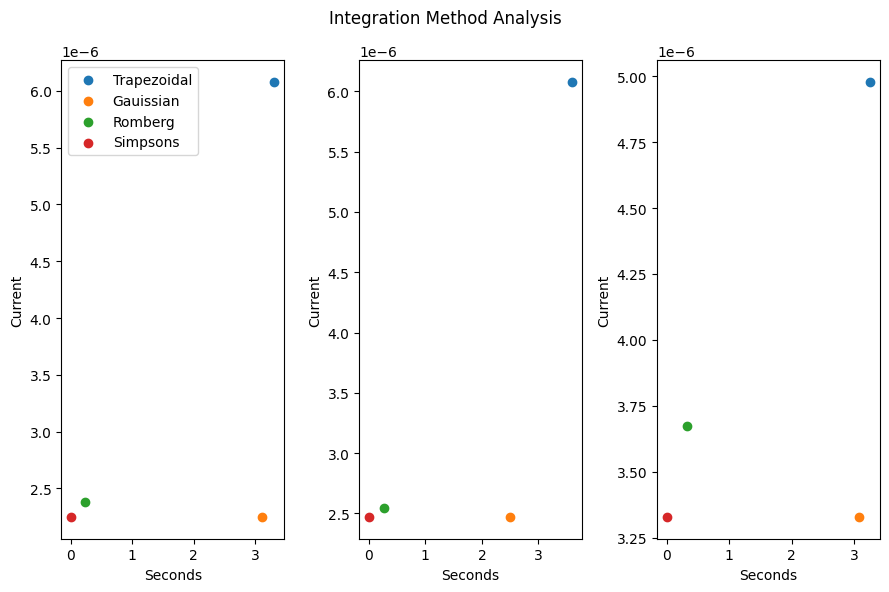

In [63]:
fig, axs = plt.subplots(1, len(J_rom))
fig.set_figheight(6)
fig.set_figwidth(9)
fig.suptitle('Integration Method Analysis')

for i in range(len(J_rom)):
  #plot all lists
  axs[i].scatter(T_trapz[i], J_trapz[i], label = 'Trapezoidal')
  axs[i].scatter(T_gauss[i], J_gauss[i], label = 'Gauissian')
  axs[i].scatter(T_rom[i], J_rom[i], label = 'Romberg')
  axs[i].scatter(T_simps[i], J_simps[i], label = 'Simpsons')
  #add labels
  axs[i].set_xlabel('Seconds')
  axs[i].set_ylabel('Current')

axs[0].legend()
# Adjust the layout to prevent subplot overlap
plt.tight_layout()
plt.show()

In [64]:
#compute average run time of each method
print("Trapezoidal", np.average(T_trapz))
print("Gaussian", np.average(T_gauss))
print("Romberg", np.average(T_rom))
print("Simpsons", np.average(T_simps))

Trapezoidal 3.3825951417287192
Gaussian 2.89336363474528
Romberg 0.27237717310587567
Simpsons 0.0085905392964681


From the above graphs it is noticeable first that the trapezoidal method takes significantly longer than all other methods and produces a result that is far larger than the other results. From here the second slowest method is the Gaussian method, which is over double the time of the other two methods. The Romberg and Simpson's method both execute extremely fast and the values produced are comparable on the first two graphs. However when compared to the third graph the Romberg integration shows to jump drastically. 

##  Conclusion and Perspectives

From the above results it is clear that the best integration method is Simpson's integration. This method was the fastest, taking between 0.002 to 0.006 seconds to run. This method also showed to produce results consistent with the Gaussian method even on large numbers. The results above also confirm that the equations used above create accurate representations of a real life photovoltaic. As when plotted as a function of depth the results produced the expected response. 


Collecting this information proved to be fairly time consuming as the equations are not commonplace and are very device specific, so a number of characteristic numbers were found through guess and check. In future iterations diving deeper into these material properties and creating more variability based on these properties. Future iterations could also dive deeper into surface recombination which for this project was ignored. 

The end result is a time efficient model, written in a python function below which is able to effectively predict how much current will result from a predicted burst of light on a known sensor.


In [65]:
def CurrentFromSensor(power, minwavelength, maxwavelength, Area, boundry, thickness, d_width):
  #define number of photons incident on the sensor
  N0 = GetNumberOfPhotons(power, minwavelength, maxwavelength)

  if maxwavelength > 1390*nano:
    maxwavelength = 1390*nano

  if minwavelength > 1390*nano:
    minwavelength = 1390*nano

  wave1 = minwavelength*10**5
  wave2 = maxwavelength*10**5

  #define internal current generation
  def Current(d):

    #find the generation rate at depth d
    Generation_Rate = lambda wave : G(wave, k, N0, d)

    #Find integration of generation rate
    Num_steps = 10**4
    wavelengthRange = np.linspace(wave1, wave2, Num_steps)
    G_wavelengths = integrate.simpson(Generation_Rate(wavelengthRange), dx = (wave2 - wave1)/Num_steps)

    #adjust to be the distance between current point and boundry
    d = Adjusted_depth(d, d_width , boundry )

    #define collection at depth d
    Collection_prob = CP(d, L)

    return G_wavelengths*Collection_prob

  d = np.linspace(0, thickness, Num_steps)
  J = q * integrate.simpson(Current(d), dx = thickness/ Num_steps)
  J *= Area

  return J

To show the usefulness of this model a hypothetical system is proposed. A researcher wants to measure a light source which can be visibly seen to be blue. The characteristics of the photovoltaic sensor are known and the researcher wants to know the power of the light beam. The researcher strikes the photovoltaic with the light and then measures that the short circuit current is 3 nano amps. From here the researcher uses the model created in this project to produce the graph below. From this graph the researcher plots 3 nano amps and finds that the light is producing 146 micro watts.

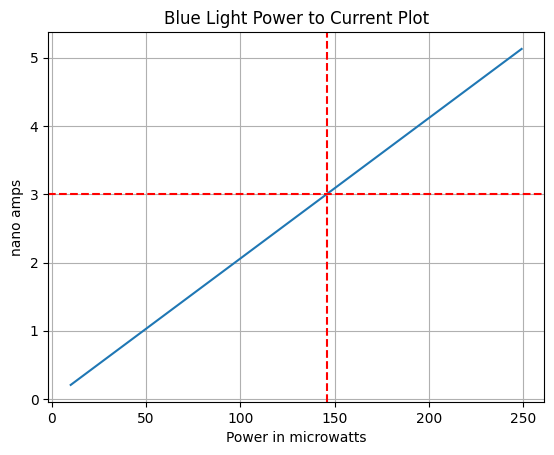

In [66]:
#define parameters
Area = (2*m)**2 #meters
b_m = 4*m
thickness = 10*m
d_width = 0.1*m

J_list = []
max_range = range(10, 250)
for i in max_range:
  J = CurrentFromSensor(i*u, 400*nano, 500*nano,  Area , b_m , thickness, d_width)
  J_list.append(J)

plt.plot(max_range, np.array(J_list)*10**9)
plt.ylabel("nano amps")
plt.xlabel("Power in microwatts")
plt.title("Blue Light Power to Current Plot")
plt.axvline(146, color = 'r', linestyle = '--')
plt.axhline(3, color = 'r', linestyle = '--')
plt.grid()

## References

[1]
C. Honsberg and S. Bowden, “Absorption Coefficient | PVEducation,” www.pveducation.org. https://www.pveducation.org/pvcdrom/pn-junctions/absorption-coefficient

[2]
“Photon energy,” Wikipedia, Oct. 30, 2019. https://en.wikipedia.org/wiki/Photon_energy

[3]
C. Honsberg and S. Bowden, “Collection Probability | PVEducation,” www.pveducation.org. https://www.pveducation.org/pvcdrom/solar-cell-operation/collection-probability

[4]
SymPy Development Team, “Integrals - SymPy 1.11 documentation,” docs.sympy.org, Aug. 22, 2022. https://docs.sympy.org/latest/modules/integrals/integrals.html (accessed Apr. 19, 2023).

‌

##  Appendices
